<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/pix2pixprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Görsel işlemeler için

Bu çalışmada amaç elimizdeki düşük çözünürlüklü görüntüleri yüksek çözünürlükl hale getiren bir model oluşturmak istiyoruz.

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing

import os
import math
import numpy as np

from IPython.display import display

Burada aslında 500 adet görsel olan basit bir dataset indiriyoruz. Manuel olarak onları düşük boyuta getirip sonrasında büyük boyutlu halleri ile eşleyerek yapay zeka eğitiminde kullancağız.

In [5]:
!wget -q "https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/10-Pix2Pix/archive.zip"


In [6]:
!unzip -q archive.zip

In [8]:
data_dir = keras.utils.get_file(origin="archive", fname="BSR")
root_dir = os.path.join(data_dir)

In [26]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)


Found 500 files.
Using 400 files for training.
Found 500 files.
Using 100 files for validation.


In [29]:
import os
import urllib.request

# Define paths
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

# Ensure test_path exists
os.makedirs(test_path, exist_ok=True)

# List of image URLs to download
image_urls = [
    "https://github.com/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/test1.jpg?raw=true",
    "https://github.com/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/test2.jpg?raw=true",
]

# Download images to test_path
for i, url in enumerate(image_urls, start=1):
    img_name = f"downloaded_{i}.jpg"
    img_path = os.path.join(test_path, img_name)
    urllib.request.urlretrieve(url, img_path)

# Load the test image paths after downloading
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)


In [30]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

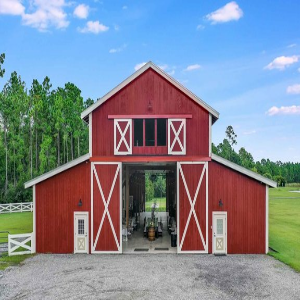

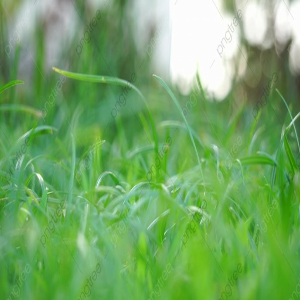

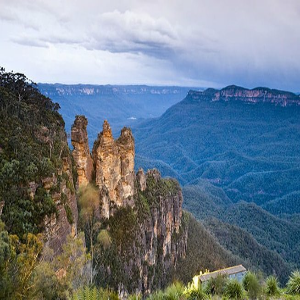

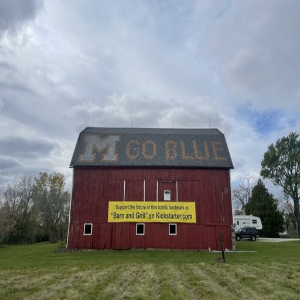

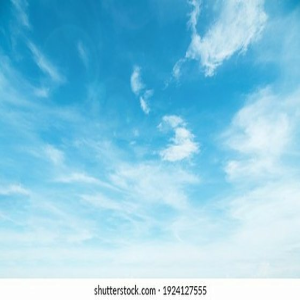

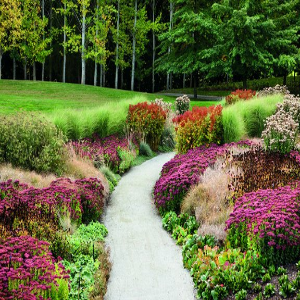

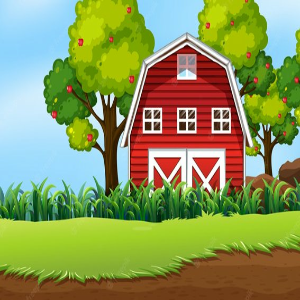

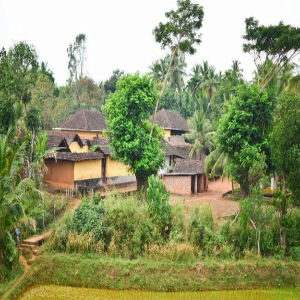

In [31]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [32]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

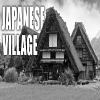

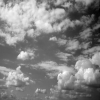

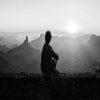

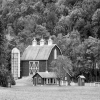

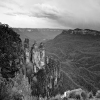

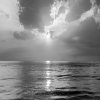

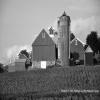

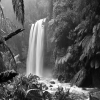

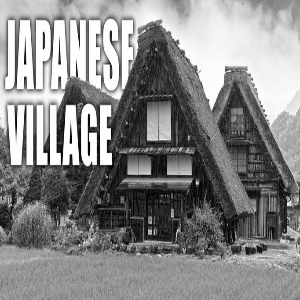

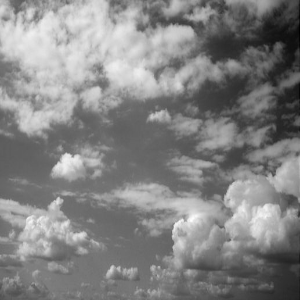

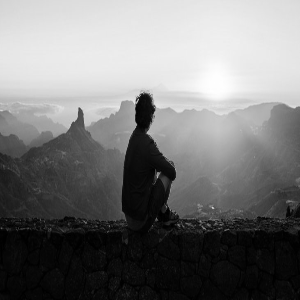

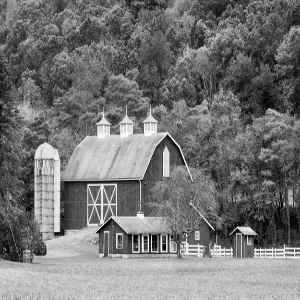

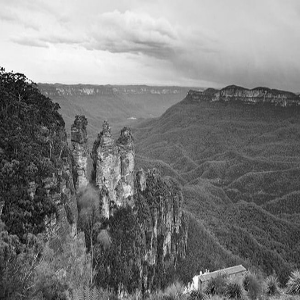

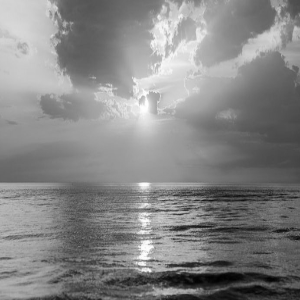

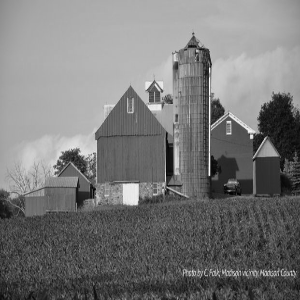

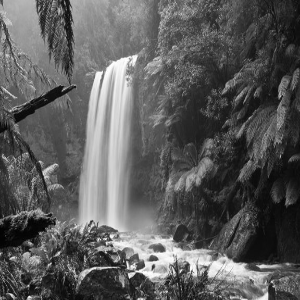

In [33]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

Model Build

In [34]:
class DepthToSpace(layers.Layer):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size

    def call(self, input):
        batch, height, width, depth = ops.shape(input)
        depth = depth // (self.block_size**2)

        x = ops.reshape(
            input, [batch, height, width, self.block_size, self.block_size, depth]
        )
        x = ops.transpose(x, [0, 1, 3, 2, 4, 5])
        x = ops.reshape(
            x, [batch, height * self.block_size, width * self.block_size, depth]
        )
        return x


def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor**2), 3, **conv_args)(x)
    outputs = DepthToSpace(upscale_factor)(x)

    return keras.Model(inputs, outputs)

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [36]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [37]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint.keras"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, None, None, 64)      │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, None, None, 9)       │           2,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depth_to_space_1 (DepthToSpace)      │ (None, None, None, 1)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,657 (233.04 KB)

 Trainable params: 59,657 (233.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)